<a href="https://colab.research.google.com/github/thuyen02/thuyen2002/blob/master/do__an.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download -d adityajn105/flickr8k

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [4]:
! mkdir train
! unzip flickr8k.zip -d train

unzip:  cannot find or open flickr8k.zip, flickr8k.zip.zip or flickr8k.zip.ZIP.


In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from numpy import array

In [11]:
df = pd.read_csv("/content/train/captions.txt")
df

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 2 columns]

In [12]:
train, val = np.split(df.sample( frac=1,random_state=42), [int(.8*len(df)),])
print(len(df), train.shape, val.shape)

40455 (32364, 2) (8091, 2)


In [17]:
image_path = '/content/gdrive/MyDrive/mn/Images/'

85    A couple and an infant , being held by the mal...
86    A couple sit on the grass with a baby and stro...
87    A couple with their newborn baby sitting under...
88    A man and woman care for an infant along the s...
89    Couple with a baby sit outdoors next to their ...
Name: caption, dtype: object


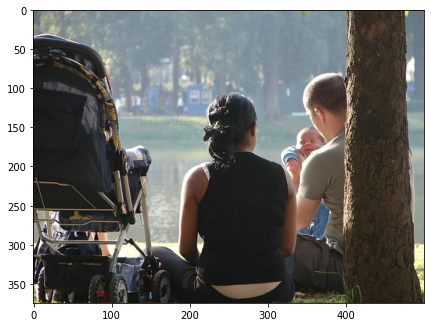

In [18]:
n = 17
img = Image.open(image_path + df['image'][5*n])
plt.figure(figsize=(7, 7))
plt.imshow(img)
print(df['caption'][5*n:5*n+5])

In [19]:
for i in range(5):
  img = Image.open(image_path + df['image'][i])
  print(img.size)

(375, 500)
(375, 500)
(375, 500)
(375, 500)
(375, 500)


In [20]:
import re
def caption_preprocessing(text, remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)
  # tokenize
  text=text.split()
  # convert to lower case
  text = [word.lower() for word in text]
  # remove hanging 's' and 'a'
  # text = [word for word in text if len(word)>1]
  
  # remove tokens with numbers in them
  text = [word for word in text if word.isalpha()]
  # store as string
  text =  ' '.join(text)

  # insert 'startseq', 'endseq' cho chuỗi
  text = 'startseq ' + text + ' endseq'
  return text

print(caption_preprocessing('chao .. ban $ hello980 it\'s a table.#'))

startseq chao ban its a table endseq


In [21]:
df['caption'] = df['caption'].apply(caption_preprocessing)

In [22]:
df['caption']

0        startseq a child in a pink dress is climbing u...
1        startseq a girl going into a wooden building e...
2        startseq a little girl climbing into a wooden ...
3        startseq a little girl climbing the stairs to ...
4        startseq a little girl in a pink dress going i...
                               ...                        
40450    startseq a man in a pink shirt climbs a rock f...
40451    startseq a man is rock climbing high in the ai...
40452    startseq a person in a red shirt climbing up a...
40453        startseq a rock climber in a red shirt endseq
40454    startseq a rock climber practices on a rock cl...
Name: caption, Length: 40455, dtype: object

In [23]:
word_counts = {}
max_length = 0
for text in df['caption']:
  words = text.split()
  max_length = len(words) if (max_length < len(words)) else max_length
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1
print(len(word_counts))
print(max_length)

8777
37


In [24]:
# Chỉ lấy các từ xuất hiện trên 10 lần
word_count_threshold = 10
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 8777 -> 1952


In [25]:
i2w = {}
w2i = {}

id = 1
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1

print(len(i2w), len(w2i))
print(i2w[300])

1952 1952
setting


In [26]:
! wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-12-01 14:37:34--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-01 14:37:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2022-12-01 14:40:14 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [27]:
! mkdir glove
! unzip glove.6B.zip -d glove

Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


In [28]:
glove_dir = '/content/glove/'
embeddings_index = {} # empty dictionary
file = open(glove_dir + 'glove.6B.200d.txt', encoding="utf-8")

for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [29]:
embeddings_index['girl'].shape

(200,)

In [30]:
embedding_dim = 200
vocab_size = len(vocab) + 1 # thêm 1 padding

In [31]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in w2i.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(1953, 200)


In [32]:
from pickle import dump, load

In [33]:
with open("/content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb", "wb") as file:
    dump(embedding_matrix, file)

In [34]:
embedding_matrix = load(open("/content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb", "rb"))
embedding_matrix.shape

(1953, 200)

In [35]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3()

96112376/96112376 [==============================] - 1s 0us/step


In [36]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [37]:
from tensorflow.keras.models import Model
# Tạo model mới, bỏ layer cuối từ inception v3
model_new = Model(model.input, model.layers[-2].output)

In [38]:

model_new.input_shape

(None, 299, 299, 3)

In [188]:
images = {}
captions = {}
for i in range(1000):
    images[df['image'][i]] = np.array(Image.open(image_path + df['image'][i]))
    try:
        captions[df['image'][i]].append(df['caption'][i])
    except:
        captions[df['image'][i]] = [df['caption'][i]]
print(len(images), len(captions))

200 200


In [189]:
with open("/content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb", "wb") as file:
    dump(captions, file)

In [190]:
captions = load(open("/content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb", "rb"))
len(captions)

200

In [191]:
images[df['image'][0]].shape

(500, 375, 3)

In [192]:
tmp = np.array([[0,2,1],[3,5,6]])
tmp = np.expand_dims(tmp, axis=0)
tmp

array([[[0, 2, 1],
        [3, 5, 6]]])

In [193]:
from keras.applications.inception_v3 import preprocess_input
# Image embedding thành vector (2048, )
def encode(image):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = np.resize(image, (299, 299, 3 ))
    # Add one more dimension
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = preprocess_input(img)

    fea_vec = model_new.predict(img) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [194]:
# Gọi hàm encode với các ảnh trong traning set
start = time()
encoding_image = {}
for id, img in images.items():
    encoding_image[id] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 255ms/step
Time taken in seconds = 68.42471385002136


In [195]:
encoding_image['1000268201_693b08cb0e.jpg'].shape

(2048,)

In [196]:
train_features = encoding_image

In [197]:
from pickle import dump, load
with open("/content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb", "wb") as file:
    dump(encoding_image, file)

In [198]:
train_features = load(open("/content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb", "rb"))
len(train_features)

200

In [199]:
model = "a"

In [200]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(captions, images, w2i, max_length, batch_size):

  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for id, caps in captions.items():
      n += 1
      image = images[id]
      for cap in caps:
        # encode the sequence
        seq = [w2i[word] for word in cap.split(' ') if word in w2i]

        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          
          # store
          X_image.append(image)
          X_cap.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        yield ([np.array(X_image), np.array(X_cap)], np.array(y))
        X_image, X_cap, y = [], [], []
        n = 0

In [201]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Input
from tensorflow.keras import optimizers

In [202]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# max_length = 35, vocab_size = 2005, embedding_dim = 200
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

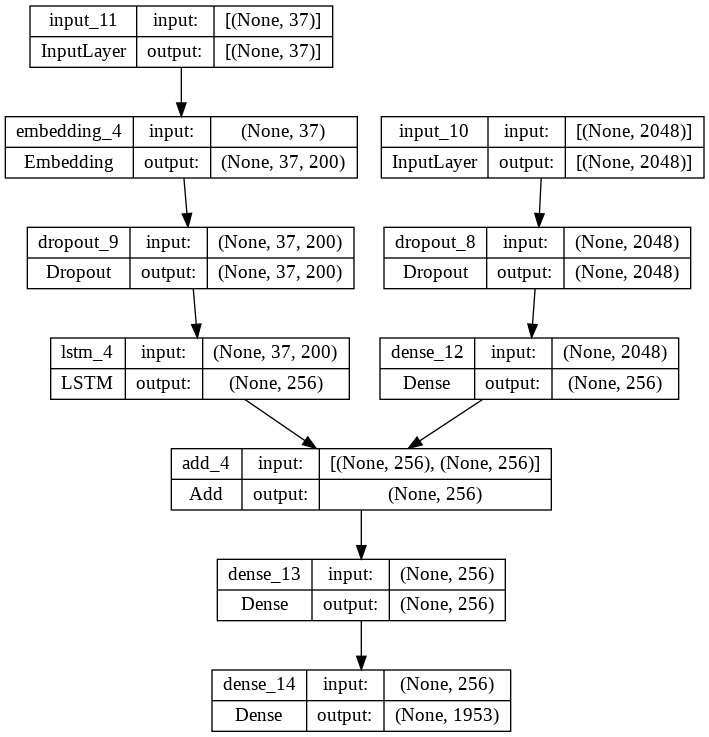

In [203]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [204]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 37)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 37, 200)      390600      ['input_11[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 2048)         0           ['input_10[0][0]']               
                                                                                            

In [205]:
model.layers[2]

In [206]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [208]:
model.optimizer.lr = 0.0001
epochs = 5
batch_size = 16
steps = len(train_features)

In [207]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [209]:

checkpoint_path = "/content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb"

In [210]:
from tensorflow.keras.callbacks import ModelCheckpoint
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only=False, save_weights_only=True, verbose=1)


In [211]:
generator = data_generator(captions=captions, images=train_features, w2i=w2i, max_length=max_length, batch_size=batch_size)
model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

200/200 [==============================] - ETA: 0s - loss: 5.2612
Epoch 1: saving model to /content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb
200/200 [==============================] - 475s 2s/step - loss: 5.2612


In [213]:
model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

200/200 [==============================] - ETA: 0s - loss: 4.3811
Epoch 1: saving model to /content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb
200/200 [==============================] - 460s 2s/step - loss: 4.3811


In [215]:
model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/Untitled19.ipynb ')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [216]:
model.save('content/gdrive/My Drive/Colab Notebooks/Image /content/train/model.png')

In [217]:
from tensorflow.keras.models import load_model
model_new = load_model('content/gdrive/My Drive/Colab Notebooks/Image /content/train/model.png')

In [218]:
model_new.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 37)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 37, 200)      390600      ['input_11[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 2048)         0           ['input_10[0][0]']               
                                                                                            

In [219]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_new.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

250    startseq a black and white dog is attempting t...
251    startseq a black and white dog jumps after a y...
252    startseq a black and white dog jumps to get th...
253    startseq a black dog is jumping up to catch a ...
254           startseq a dog jumps to catch a toy endseq
Name: caption, dtype: object


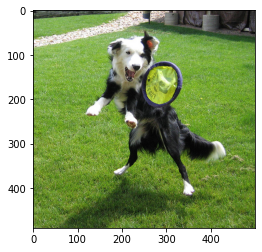

a dog dog in a and


In [220]:
pic = list(train_features.keys())[50]
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + pic)
print(df['caption'][df['image'] == pic])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print(predict)

In [221]:
pic

'1067180831_a59dc64344.jpg'

30    startseq a black and white dog is running in a...
31    startseq a black and white dog is running thro...
32    startseq a boston terrier is running in the gr...
33    startseq a boston terrier is running on lush g...
34    startseq a dog runs on the green grass near a ...
Name: caption, dtype: object


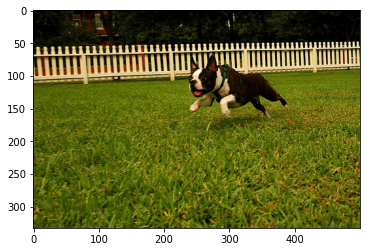

a dog dog in a in a


In [222]:
pic = '1009434119_febe49276a.jpg'
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + pic)
print(df['caption'][df['image'] == pic])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print(predict)